In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import pickle
import os
import plotnine
import warnings
from plotnine import *
import pandas as pd
from pandas import Series
from keras.models import load_model
from kerasAC.metrics import recall, specificity, fpr, fnr, precision, f1
from kerasAC.custom_losses import ambig_binary_crossentropy, ambig_mean_squared_error
from kerasAC.generators import *
import pybedtools
import tabix

Using TensorFlow backend.


## Select GPU

In [3]:
warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
!env | grep "CUDA"

grep: warning: GREP_OPTIONS is deprecated; please use an alias or script
CUDA_VISIBLE_DEVICES=1
CUDA_HOME=/usr/local/cuda-10.0


## Get Model and Peak File Addresses

In [3]:
model_dict={}
idr_dict={}
for sample in ['microglia']:
    model_dict[sample]='/mnt/lab_data3/soumyak/adpd/deeplearning/models/regression/single_cell/'+sample+'.model.'
    idr_dict[sample]='/mnt/lab_data2/annashch/alzheimers_parkinsons/pseudobulk/rGREAT/idr/Cluster24.bed'

## Get GWAS Tag SNPs

In [8]:
gwas = pd.read_csv('/mnt/lab_data3/soumyak/adpd/gwas/GWAS_Kunkle2019.txt.gz', sep='\t', keep_default_na=False)
new_gwas = gwas.loc[gwas['pvalue'] < 5e-8]
new_cols = {}
for i in new_gwas.columns:
    new_cols[i] = i.upper()
new_gwas.rename(columns=new_cols, inplace=True)
new_gwas.rename(columns={'SNP_POS':'POS', 'EFFECT_ALLELE':'ALT', 'NON_EFFECT_ALLELE': 'REF'}, inplace=True)
new_gwas['CHR'] = new_gwas['CHR'].apply(lambda x: 'chr' + str(x))
new_gwas = new_gwas[['CHR','POS','RSID','PVALUE','REF','ALT','EFFECT_DIRECTION','BETA','SE','MARKERNAME']]
display(new_gwas.head())
display(new_gwas.tail())
print(new_gwas.shape)
new_gwas.to_csv('/mnt/lab_data3/soumyak/adpd/gwas/tag_snps_kunkle.csv', sep='\t', index=False)

/users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,CHR,POS,RSID,PVALUE,REF,ALT,EFFECT_DIRECTION,BETA,SE,MARKERNAME
706229,chr1,207679307,rs4844600,1.598000e-13,G,A,+,0.1324,0.0179,rs4844600
706246,chr1,207684192,rs12037841,1.769000e-15,G,T,+,0.1473,0.0185,rs12037841
706250,chr1,207685786,rs4266886,2.090000e-14,C,T,+,0.1365,0.0179,rs4266886
706251,chr1,207685965,rs4562624,1.826000e-15,C,A,+,0.1472,0.0185,rs4562624
706281,chr1,207692049,rs6656401,2.169000e-15,G,A,+,0.1465,0.0185,rs6656401


,CHR,POS,RSID,PVALUE,REF,ALT,EFFECT_DIRECTION,BETA,SE,MARKERNAME
10628103,chr8,27466181,rs1532277,3.785000e-16,C,T,-,-0.1255,0.0154,rs1532277
10628104,chr8,27466315,rs1532278,3.266000e-16,C,T,-,-0.1258,0.0154,rs1532278
10628110,chr8,27467686,rs9331896,3.624000e-16,C,T,+,0.1269,0.0156,rs9331896
10628111,chr8,27467821,rs2070926,1.006000e-15,G,C,-,-0.1254,0.0156,rs2070926
10628112,chr8,27468503,rs867230,3.492000e-17,C,A,+,0.1333,0.0158,rs867230


(1547, 10)


## Get GWAS LD SNPs

## Constant Addresses

In [7]:
ref_fasta='/mnt/data/annotations/by_release/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta'
snp_prefix='/mnt/lab_data3/soumyak/adpd/gwas/'

## Get Predictions from all Folds

In [8]:
def get_preds_all_folds(task, gwas, ref_fasta=ref_fasta, snp_prefix=snp_prefix, n_folds=10):
    
    if gwas == 'AD':
        all_snps_basename='GWAS_Alzheimers_Kunkle_2019_snps.with.ld.buddies_AllSNPs-hg38.formatted.txt'
    else:
        all_snps_basename='GWAS_Parkinsons_23andme_2018_snps.with.ld.buddies_AllSNPs-hg38.formatted.txt'

    model_prefix=model_dict[task]
    idr_peaks=idr_dict[task]
    
    #for fold in range(n_folds): 
    for fold in [7]:
        print(fold)
        #load the model
        custom_objects={"recall":recall,
                        "sensitivity":recall,
                        "specificity":specificity,
                        "fpr":fpr,
                        "fnr":fnr,
                        "precision":precision,
                        "f1":f1,
                        "ambig_binary_crossentropy":ambig_binary_crossentropy,
                        "ambig_mean_squared_error":ambig_mean_squared_error}
        model=load_model(model_prefix+str(fold),custom_objects=custom_objects)
        print("loaded model")
        #get reference allele predictions 
        snp_file='/'.join([snp_prefix,all_snps_basename])+'.'+str(fold)
        snp_ref_generator=SNPGenerator(data_path=snp_file,
                                       ref_fasta=ref_fasta,
                                       allele_col="REF")
        snp_ref_predictions=model.predict_generator(snp_ref_generator,
                                                    max_queue_size=5000, 
                                                    workers=40, 
                                                    use_multiprocessing=True,
                                                    verbose=1)
        print("got snp ref predictions")
        #get alternate allele predictions 
        snp_alt_generator=SNPGenerator(snp_file,
                                       ref_fasta=ref_fasta,
                                       allele_col="ALT")
        snp_alt_predictions=model.predict_generator(snp_alt_generator,
                                                    max_queue_size=5000, 
                                                    workers=40, 
                                                    use_multiprocessing=True, verbose=1)
        print("got snp alt predictions")
        snp_ref_generator.data['ref_pred']=snp_ref_predictions
        snp_ref_generator.data['alt_pred']=snp_alt_predictions
        snp_ref_generator.data.to_csv(task+'.'+str(fold)+'.GWAS_SNP_predictions.txt',sep='\t')

In [9]:
get_preds_all_folds('microglia','AD')

W0820 02:23:19.559049 140697662969664 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 02:23:19.586170 140697662969664 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0820 02:23:19.612837 140697662969664 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0820 02:23:19.613791 140697662969664 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_defa

7


W0820 02:23:21.771857 140697662969664 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0820 02:23:21.832978 140697662969664 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0820 02:23:22.071995 140697662969664 deprecation.py:506] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0820 02:23:22.835078 140697662969664 deprecation_wra

loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(71, 8)
1/1 [==============================] - 6s 6s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(71, 8)
1/1 [==============================] - 3s 3s/step
got snp alt predictions


## Get Results from all Folds

In [10]:
def get_results_all_folds(task):
    print("TASK: ",task)
    #for fold in range(10):
    for fold in [7]:
        print("FOLD: ",fold)
        snp_predictions=pd.read_csv(task+'.'+str(fold)+'.GWAS_SNP_predictions.txt',sep='\t')
        print("All SNPs:")
        display(snp_predictions.shape)
        snp_bed = pybedtools.BedTool.from_dataframe(snp_predictions)
        idr_bed = pybedtools.BedTool(idr_dict[task])
        pos_snps_bed = snp_bed.intersect(idr_bed, u=True)
        if pos_snps_bed.count() > 0:
            pos_snps = pybedtools.BedTool.to_dataframe(pos_snps_bed)
            pos_snps.columns = snp_predictions.columns
            print("SNPs in Peaks:")
            display(pos_snps.shape)
            plotnine.options.figure_size = (6,6)
            display((ggplot(pos_snps,
                aes(x="ref_pred",y="alt_pred",label='ID'))+
            geom_point(alpha=0.3,color='red')+
            theme_bw(20)+
            xlab("Reference Allele Prediction")+
            ylab("Alternate Allele Prediction")+
            ggtitle("GWAS Variants")))
            pos_snps['delta']=pos_snps['alt_pred']-pos_snps['ref_pred']
            pos_snp_predictions_sorted=pos_snps.sort_values(by=['delta'])
            print("Negative SNPs in Peaks:")
            display(pos_snp_predictions_sorted.head(10))
            print("Positive SNPs in Peaks:")
            display(pos_snp_predictions_sorted.tail(10))
        snp_bed = pybedtools.BedTool.from_dataframe(snp_predictions)
        idr_bed = pybedtools.BedTool(idr_dict[task])
        neg_snps_bed = snp_bed.intersect(idr_bed, v=True)
        if neg_snps_bed.count() > 0:
            neg_snps = pybedtools.BedTool.to_dataframe(neg_snps_bed)
            neg_snps.columns = snp_predictions.columns
            print("SNPs NOT in Peaks:")
            display(neg_snps.shape)
            plotnine.options.figure_size = (6,6)
            display((ggplot(neg_snps,
                aes(x="ref_pred",y="alt_pred",label='ID'))+
            geom_point(alpha=0.3,color='red')+
            theme_bw(20)+
            xlab("Reference Allele Prediction")+
            ylab("Alternate Allele Prediction")+
            ggtitle("GWAS Variants")))
            neg_snps['delta']=neg_snps['alt_pred']-neg_snps['ref_pred']
            neg_snp_predictions_sorted=neg_snps.sort_values(by=['delta'])
            print("Negative SNPs OUTSIDE Peaks:")
            display(neg_snp_predictions_sorted.head(10))
            print("Positive SNPs OUTSIDE Peaks:")
            display(neg_snp_predictions_sorted.tail(10))

TASK:  microglia
FOLD:  7
All SNPs:


(71, 13)

SNPs in Peaks:


(5, 13)

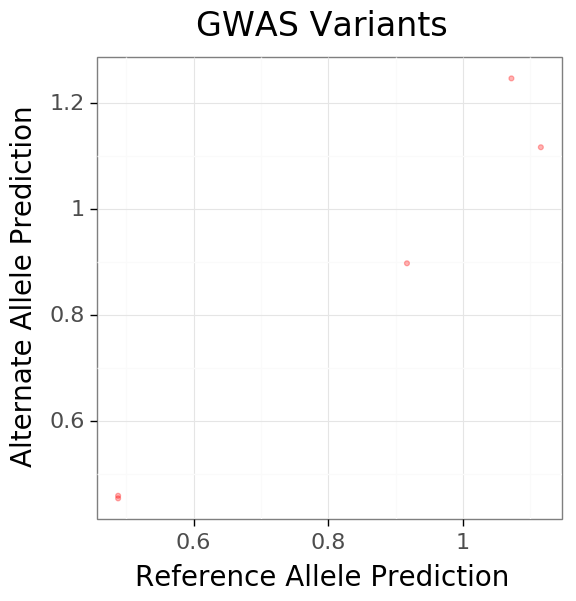

<ggplot: (8793203515270)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
2,chr11,47881330,47881331,rs12364432,G,A,0.853993,chr11,47893747,11,rs34467936,0.487843,0.454317,-0.033526
3,chr11,47881330,47881331,rs12364432,G,C,0.853993,chr11,47893747,11,rs34467936,0.487843,0.459305,-0.028538
4,chr17,58332679,58332680,rs2526377,A,G,0.812589,chr17,58331728,24,rs2632516,0.916820,0.897456,-0.019363
0,chr11,60251787,60251788,rs3041800,G,GTA,0.988537,chr11,60254475,4,rs1582763,1.115667,1.116208,0.000542
1,chr11,86156832,86156833,rs10792832,A,G,0.960560,chr11,86157598,6,rs3851179,1.071964,1.246002,0.174039


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
2,chr11,47881330,47881331,rs12364432,G,A,0.853993,chr11,47893747,11,rs34467936,0.487843,0.454317,-0.033526
3,chr11,47881330,47881331,rs12364432,G,C,0.853993,chr11,47893747,11,rs34467936,0.487843,0.459305,-0.028538
4,chr17,58332679,58332680,rs2526377,A,G,0.812589,chr17,58331728,24,rs2632516,0.916820,0.897456,-0.019363
0,chr11,60251787,60251788,rs3041800,G,GTA,0.988537,chr11,60254475,4,rs1582763,1.115667,1.116208,0.000542
1,chr11,86156832,86156833,rs10792832,A,G,0.960560,chr11,86157598,6,rs3851179,1.071964,1.246002,0.174039


SNPs NOT in Peaks:


(64, 13)

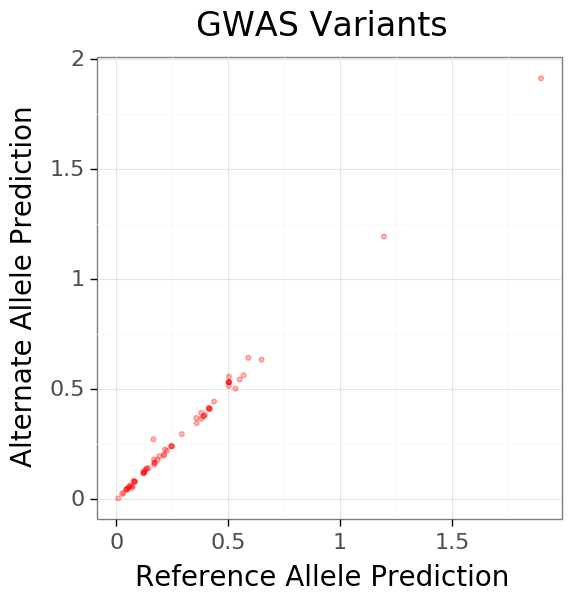

<ggplot: (8793203297477)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
46,chr11,121564743,121564744,rs1362144798,AT,A,0.857167,chr11,121564878,15,rs11218343,0.531974,0.502616,-0.029358
20,chr11,47814509,47814510,rs12785833,T,A,0.805946,chr11,47893747,11,rs34467936,0.071190,0.053179,-0.018011
23,chr11,47825158,47825159,rs11039416,G,A,0.810329,chr11,47893747,11,rs34467936,0.649033,0.634267,-0.014766
10,chr17,63460786,63460787,rs138190086,G,A,1.000000,chr17,63460787,67,rs138190086,0.358790,0.345517,-0.013273
4,chr11,121564877,121564878,rs11218343,T,A,1.000000,chr11,121564878,15,rs11218343,0.378580,0.365467,-0.013113
57,chr17,58326987,58326988,rs2526378,A,G,0.840289,chr17,58331728,24,rs2632516,0.211517,0.198536,-0.012981
21,chr11,47814509,47814510,rs12785833,T,C,0.805946,chr11,47893747,11,rs34467936,0.071190,0.058480,-0.012710
11,chr11,11526633,11526634,rs148178636,C,T,1.000000,chr11,11526634,69,rs148178636,0.395753,0.383055,-0.012698
1,chr11,47358788,47358789,rs3740688,G,A,1.000000,chr11,47358789,8,rs3740688,0.389599,0.377191,-0.012408
2,chr11,47358788,47358789,rs3740688,G,T,1.000000,chr11,47358789,8,rs3740688,0.389599,0.377615,-0.011984


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
7,chr11,112688619,112688620,rs72993825,C,T,1.000000,chr11,112688620,31,rs72993825,1.898626,1.911048,0.012422
17,chr11,47783925,47783926,rs35805829,T,C,0.804142,chr11,47893747,11,rs34467936,0.168004,0.180967,0.012963
5,chr11,121564877,121564878,rs11218343,T,C,1.000000,chr11,121564878,15,rs11218343,0.378580,0.392856,0.014276
47,chr11,121564743,121564744,rs397961084,A,AT,0.857167,chr11,121564878,15,rs11218343,0.502616,0.531974,0.029358
45,chr11,121564743,121564744,rs56704272,A,AT,0.857167,chr11,121564878,15,rs11218343,0.502616,0.531974,0.029358
42,chr11,121564743,121564744,rs529960410,A,AT,0.857167,chr11,121564878,15,rs11218343,0.502616,0.531974,0.029358
43,chr11,121564743,121564744,rs529960410,A,ATT,0.857167,chr11,121564878,15,rs11218343,0.502616,0.531974,0.029358
59,chr11,76737241,76737242,rs11236918,C,A,0.978789,chr11,76736079,73,rs12291515,0.589860,0.642312,0.052452
41,chr11,121564743,121564744,rs529960410,A,AG,0.857167,chr11,121564878,15,rs11218343,0.502616,0.557323,0.054707
13,chr11,86145144,86145145,rs7110631,C,G,0.837503,chr11,86157598,6,rs3851179,0.165451,0.273076,0.107625


In [11]:
get_results_all_folds('microglia')